# TP2 - Estimation de densité
----

## Chargement et visualisation des données 

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

Liste des types de POI furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar


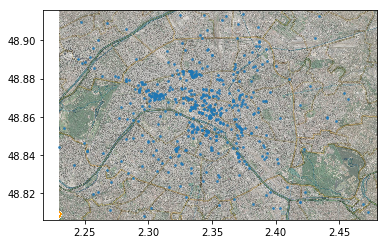

In [64]:
plt.ion()
parismap = mpimg.imread('data/paris-48.806-2.23--48.916-2.48.jpg')

## coordonnees GPS de la carte
xmin,xmax = 2.23,2.48   ## coord_x min et max
ymin,ymax = 48.806,48.916 ## coord_y min et max

def show_map():
    plt.imshow(parismap,extent=[xmin,xmax,ymin,ymax],aspect=1.5)
    ## extent pour controler l'echelle du plan
    
poidata = pickle.load(open("data/poi-paris.pkl","rb"))
## liste des types de point of interest (poi)
print("Liste des types de POI" , ", ".join(poidata.keys()))

## Choix d'un poi
typepoi = "night_club"

## Creation de la matrice des coordonnees des POI
geo_mat = np.zeros((len(poidata[typepoi]),2))
for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0][::-1]

## Affichage brut des poi
show_map()
## alpha permet de regler la transparence, s la taille
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)

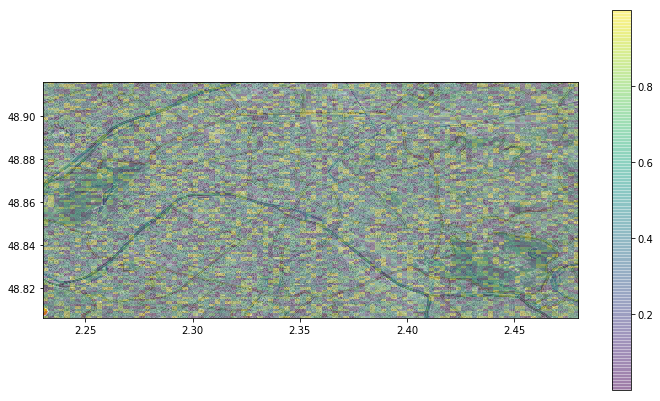

In [4]:
# discretisation pour l'affichage des modeles d'estimation de densite
steps = 100
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[xx.ravel(),yy.ravel()]

# A remplacer par res = monModele.predict(grid).reshape(steps,steps)
res = np.random.random((steps,steps))
plt.figure(figsize = (12,7))
show_map()
plt.imshow(res,extent=[xmin,xmax,ymin,ymax],interpolation='none',\
               alpha=0.3,origin = "lower")
plt.colorbar()
#plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.3)

## Expérimentations

### Affichage

In [5]:
def affichage(xmin, xmax, ymin, ymax, steps, modele):
    # discretisation pour l'affichage des modeles d'estimation de densite
    xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
    grid = np.c_[xx.ravel(),yy.ravel()]

    res = modele.predict(grid).reshape(steps,steps)
    plt.figure(figsize = (12,7))
    show_map()
    plt.imshow(res,extent=[xmin,xmax,ymin,ymax],interpolation='none',\
                   alpha=0.3,origin = "lower")
    plt.colorbar()
    #plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.3)
    return res

### Méthode des histogrammes
----

In [6]:
class HistogramMethod:
    """Classe modélisant la méthode des histogrammes"""
        
    def __init__(self, geo_mat):
        self.geo_mat = geo_mat
        
    # Inutile de faire un apprentissage
        
    def predict(self, grid):
        res = np.zeros(len(grid))
        for point in geo_mat:
            for i, xy in enumerate(grid):
                if point[0] < xy[0] and point[1] < xy[1]:
                    res[i] += 1
                    break
        res /= len(geo_mat)
        return res


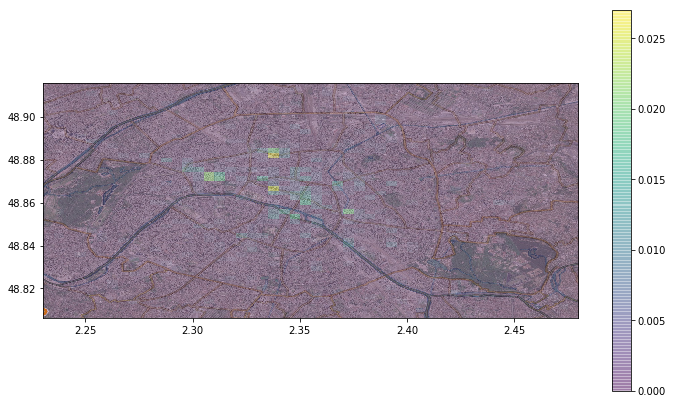

In [7]:
steps = 50
res = affichage(xmin, xmax, ymin, ymax, steps, HistogramMethod(geo_mat))

### Estimation non paramétrique par noyaux
----

In [23]:
class KernelMethod:
    """Classe modélisant une méthode à noyaux """
    
    def __init__(self, geo_mat, hn):
        self.geo_mat = geo_mat
        self.hn = hn
        
    def predict(self, grid):
        """A definir"""
        return
    

#### Fenêtre de Parzen

In [49]:
def isOnParzenWindow(x):
    """ np.array -> int
        retourne 1 si x appartient à la fenêtre sinon 0
    """
    # Si x et y sont inférieurs à 0.5, on obtiendra un tableau contenant 2 valeurs True
    return 1 if sum(np.abs(x) <= 0.5) == 2 else 0


class ParzenMethod(KernelMethod):
    """Classe modélisant la méthode utilisant la fenêtre de Parzen"""

    def predict(self, grid):
        res = np.zeros(len(grid))
        # Hypothèse : Nos données sont de dimensions 2
        Vn = self.hn ** 2
        for i, xy in enumerate(grid):
            # On décide de ne pas normaliser car le nombre de points dans chaque 
            # hypercube n'est pas équilibré
            # A revoir...
            res[i] = sum(isOnParzenWindow((point - xy)/self.hn) for point in geo_mat)
        return res
    

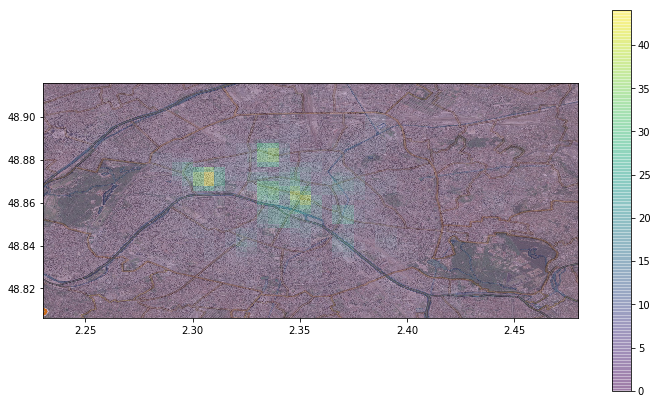

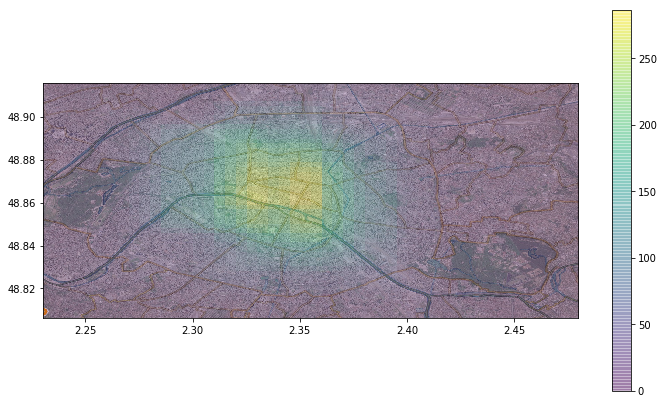

In [10]:
steps = 50
res = affichage(xmin, xmax, ymin, ymax, steps, ParzenMethod(geo_mat, hn=0.01))
res2 = affichage(xmin, xmax, ymin, ymax, steps, ParzenMethod(geo_mat, hn=0.05))

#### Noyau gaussien

In [48]:
def GaussianPhi(x):
    # Si x et y sont inférieurs à 0.5, on obtiendra un tableau contenant 2 valeurs True
    return np.prod( 1/(np.sqrt(2*np.pi))*np.exp(-0.5*(x**2)) )
    

class GaussianMethod(KernelMethod):
    """Classe modélisant la méthode utilisant un noyau gaussien"""

    def predict(self, grid):
        res = np.zeros(len(grid))
        # Hypothèse : Nos données sont de dimensions 2
        Vn = self.hn ** 2
        for i, xy in enumerate(grid):
            res[i] = sum(GaussianPhi((point - xy)/self.hn) for point in geo_mat)
        return res

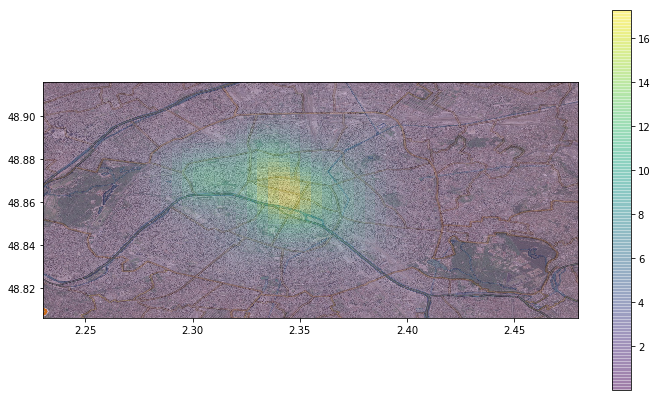

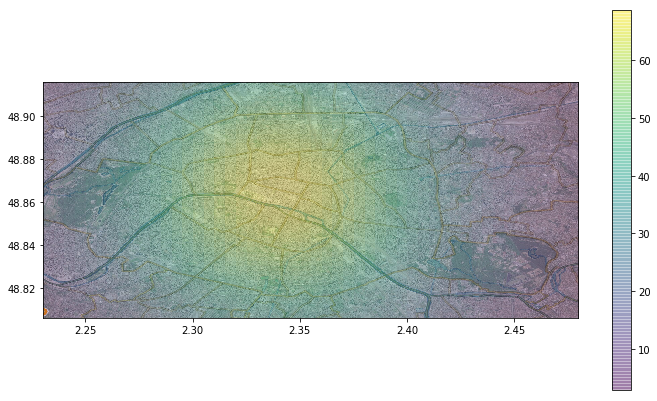

In [47]:
steps = 50
res = affichage(xmin, xmax, ymin, ymax, steps, GaussianMethod(geo_mat, hn=0.01))
res2 = affichage(xmin, xmax, ymin, ymax, steps, GaussianMethod(geo_mat, hn=0.05))

#### Noyau Laplace

In [50]:
def LaplacePhi(x):
    # Si x et y sont inférieurs à 0.5, on obtiendra un tableau contenant 2 valeurs True
    return np.prod( 0.5*np.exp(-np.abs(x)) )
    

class LaplaceMethod(KernelMethod):
    """Classe modélisant la méthode utilisant un noyau laplacien"""

    def predict(self, grid):
        res = np.zeros(len(grid))
        # Hypothèse : Nos données sont de dimensions 2
        Vn = self.hn ** 2
        for i, xy in enumerate(grid):
            res[i] = sum(LaplacePhi((point - xy)/self.hn) for point in geo_mat)
        return res

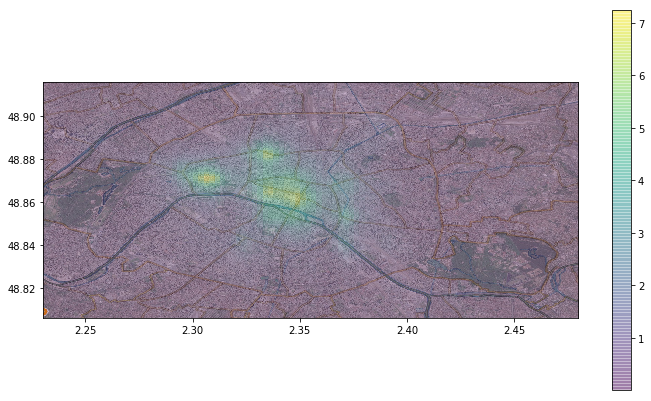

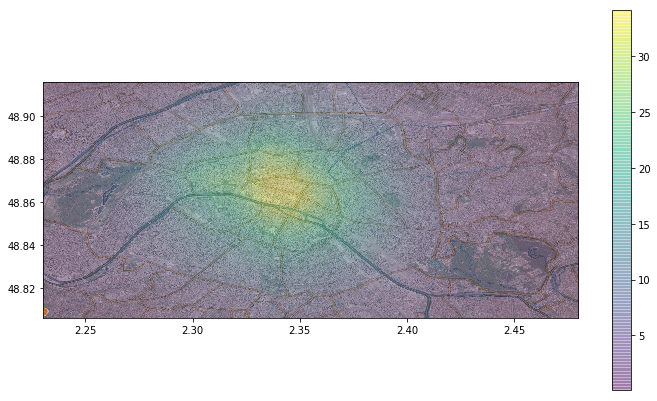

In [53]:
steps = 100
res = affichage(xmin, xmax, ymin, ymax, steps, LaplaceMethod(geo_mat, hn=0.005))
res2 = affichage(xmin, xmax, ymin, ymax, steps, LaplaceMethod(geo_mat, hn=0.02))

#### [Q] - Que se passe-t-il pour une faible/forte disrétisation pour la méthode des histogrammes ?

[R] - Une faible discrétisation provoque une faible précision et ne permet donc pas de bien visualiser les différentes variations. Au contraire, une forte discrétisation induit une forte sensibilité avec notamment la présence de valeurs extrêmes et par conséquent, de fortes discontinuités.

#### [Q] - Quel est le rôle des paramètres des méthodes à noyaux ?

[R] - Le but des méthodes à noyaux est de prendre en compte les points voisins du point étudié afin de résoudre le problème de la discrétisation. Le rôle des paramètres est de déterminer l'espace de voisinage (l'espace qui détermine les voisins à prendre en compte).

#### [Q] - Comment choisir de manière automatique les meilleurs paramètres ?

[R] - (Hypothèse) Plus le nombre de données augmente, plus un lissage avec un hn grand pourrait être nécessaire. Lorsque le nombre de données tend vers l'infini, hn n'a quasiment plus d'impact sur l'estimation.

A revoir

#### [Q] - La question reliée : comment estimer la qualité de votre modèle ? 

[R] - A revoir et répondre

### Test avec différents POI
----

### Classification supervisée
----

In [ ]:
class Classifier:

    def fit(self, X, Y):
        """ X : base d'exemples d'apprentissage
            Y : labels
        """
        """A definir"""
        return
    
    def predict(self, x):
        """ x : un exemple """
        """A definir"""
        return
    
    def accuracy(self, X, Y):
        """ X : exemples, Y : labels """
        
        pred = np.zeros(len(X))
        for i in range(len(X)):
            pred[i] = self.predict(x)
        return len(np.where(pred == Y)[0])/len(X)
        

#### Nadaraya-Watson

#### K-means

In [ ]:
class Kmean(Classifier):
    
    """ A faire """